In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    accuracy_score,
    multilabel_confusion_matrix
)
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate

import pandas as pd
import numpy as np
import pickle
import copy

from typing import Tuple, List

## Preparing dataset

In [3]:
df = pd.read_csv('scada-sysmon-sysstat.csv')

In [4]:
df.head()

,total_fpackets,total_fvolume,total_bpackets,total_bvolume,min_fpktl,mean_fpktl,max_fpktl,std_fpktl,min_bpktl,mean_bpktl,...,ID19,ID20,ID21,ID22,classe_atk_num,classe_num,class_atk_sysmon,class_sysmon,class_atk_sysstat,class_sysstat
0,-0.531611,-0.973446,-1.166558,-1.349828,-1.399612,-1.757253,-1.586249,-0.911927,-0.516389,-1.458594,...,0.0,0.0,0.0,-0.287435,0,0,acunetix,ataque,acunetix,ataque
1,-0.531611,-0.973446,-1.166558,-1.349828,-1.399612,-1.757253,-1.586249,-0.911927,-0.516389,-1.458594,...,0.0,0.0,0.0,-0.287435,0,0,acunetix,ataque,acunetix,ataque
2,-0.344116,-0.792588,-1.166558,-1.349828,-1.399612,-1.948322,-1.586249,-0.911927,-0.516389,-1.458594,...,0.0,0.0,0.0,-0.287435,0,0,acunetix,ataque,acunetix,ataque
3,-0.344116,-0.792588,-1.166558,-1.349828,-1.399612,-1.948322,-1.586249,-0.911927,-0.516389,-1.458594,...,0.0,0.0,0.0,-0.287435,0,0,acunetix,ataque,acunetix,ataque
4,-0.344116,-0.792588,-1.166558,-1.349828,-1.399612,-1.948322,-1.586249,-0.911927,-0.516389,-1.458594,...,0.0,0.0,0.0,-0.287435,0,0,acunetix,ataque,acunetix,ataque


In [5]:
# Dropping meaningless columns based on RF feature importances for iptables, 
# snort_win, and snort_linux
df.drop(['min_idle', 'mean_idle', 'max_idle', 'std_idle', 'furg_cnt', 'burg_cnt', 'std_active'], axis=1, inplace=True)

In [6]:
df['tipo'].unique()

array(['acunetix-xss', 'acunetix-sql-injection', 'nmap-port-scan',
       'arachni-code-injection', 'smod-dos-write-single-coils',
       'nessus-advanced-scan', 'smod-dos-write-single-register',
       'smod-read-coils', 'smod-read-holding-register',
       'smod-read-input-register', 'smod-write-single-coils',
       'smod-write-single-register', 'smod-get-func', 'smod-scanner-uid',
       'normal'], dtype=object)

In [7]:
le = LabelEncoder()
df['label_tipo'] = le.fit_transform(df['tipo'])

In [8]:
', '.join(i for i in df.columns.values)

'total_fpackets, total_fvolume, total_bpackets, total_bvolume, min_fpktl, mean_fpktl, max_fpktl, std_fpktl, min_bpktl, mean_bpktl, max_bpktl, std_bpktl, min_fiat, mean_fiat, max_fiat, std_fiat, min_biat, mean_biat, max_biat, std_biat, duration, min_active, mean_active, max_active, sflow_fpackets, sflow_fbytes, sflow_bpackets, sflow_bbytes, fpsh_cnt, bpsh_cnt, total_fhlen, total_bhlen, timestamp, iptables, snort_linux, snort_win, tipo, attack, txpck, rxkB, txkB, rxcmp, txcmp, rxmcst, ifutil, kbmemfree, kbmemused, memused, kbbuffers, kbcached, kbcommit, commit, kbactive, kbinact, kbdirty, kbanonpg, kbslab, kbkstack, kbpgtbl, kbvmused, CPU, nice, sys, iowait, steal, irq, soft, guest, gnice, idle, pswpin, pswpout, proc, cswch, intr, sum, classe_atk_num_sysmon, classe_num_sysmon, ID1, ID2, ID3, ID4, ID5, ID6, ID7, ID8, ID9, ID10, ID11, ID12, ID13, ID14, ID15, ID16, ID17, ID18, ID19, ID20, ID21, ID22, classe_atk_num, classe_num, class_atk_sysmon, class_sysmon, class_atk_sysstat, class_syssta

In [9]:
list(df.columns.values).index('attack')

37

## Splitting features into ```network traffict``` and ```OS metrics``` columns

In [10]:
# 'attack' index + itself
net_columns = [*df.columns.values[:np.where(df.columns.values == 'attack')[0][0] + 1], 'label_tipo']

os_columns = list(df.columns.values[np.where(df.columns.values == 'attack')[0][0]:-1])

In [11]:
def is_hp(x):
    if x['iptables'] == 0 and x['snort_win'] == 0 and x['snort_linux'] == 0 and x['attack'] == 1:
        return 1
    return 0

# df['honeypot'] = df.apply(is_hp, axis=1)

### Some tests

In [12]:
iptables = df.drop(['snort_win', 'snort_linux'], axis=1)
iptables['name'] = 'iptables'

snort_linux = df.drop(['snort_win', 'iptables'], axis=1)
snort_linux['name'] = 'snort_linux'

snort_win = df.drop(['iptables', 'snort_linux'], axis=1)
snort_win['name'] = 'snort_win'

In [13]:
get_X = lambda df: df.drop(['tipo', 'attack', 'name', 'label_tipo', df.name.unique()[0]], axis=1)
get_y = lambda df: df[df.name.unique()[0]]
get_feature_importances = lambda clf, df: pd.Series(clf.feature_importances_, df.columns).sort_values(ascending=False)

def get_X_y(df: pd.DataFrame, rs: int = 42, ts: float = 0.4) -> tuple:
    """ Wrapper function to apply and return train_test_split values """
    return train_test_split(get_X(df), get_y(df), random_state=rs, test_size=ts)

def evaluate_features(clf: object, df: pd.DataFrame, rs: int = 42, ts: float = 0.4) -> tuple:
    """ Function to train and test a classifier based on the hold-out 
        experimental protocol. 

        Returns a tuple containing the classification report of the estimator
        and a pandas series of the most important features.    
    """
    X_train, X_test, y_train, y_test = get_X_y(df, rs, ts)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    cr = classification_report(y_test, y_pred)
    fi = get_feature_importances(clf, X_train)
    cm = confusion_matrix(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    
    return cr, fi, cm, acc

In [14]:
# Storing key/value where each value corresponds a tuple containing a classification
# report and feature importances of a given dataframe
cr, fi, cm, acc = evaluate_features(RandomForestClassifier(), iptables)
print(cr)
print(fi)
print(cm)
print(acc)

ValueError: could not convert string to float: 'arachni'

In [ ]:
cr, fi, cm, acc = evaluate_features(RandomForestClassifier(), snort_linux)
print(cr)
print(fi)
print(cm)
print(acc)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     69536
           1       0.98      0.99      0.99     25439

    accuracy                           0.99     94975
   macro avg       0.99      0.99      0.99     94975
weighted avg       0.99      0.99      0.99     94975

std_fpktl         0.149186
max_fpktl         0.146640
bpsh_cnt          0.116565
timestamp         0.111207
mean_fpktl        0.097323
max_bpktl         0.086306
min_fpktl         0.055849
total_fhlen       0.054201
mean_bpktl        0.044298
std_bpktl         0.033880
total_fpackets    0.022270
sflow_fpackets    0.019774
total_bvolume     0.010014
sflow_fbytes      0.009020
total_fvolume     0.008681
total_bhlen       0.007980
sflow_bbytes      0.005918
fpsh_cnt          0.004645
sflow_bpackets    0.002608
std_biat          0.002348
total_bpackets    0.001911
min_fiat          0.001774
max_active        0.001358
mean_biat         0.001112
duration          0.00090

In [ ]:
cr, fi, cm, acc = evaluate_features(RandomForestClassifier(), snort_win)
print(cr)
print(fi)
print(cm)
print(acc)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     52323
           1       0.99      0.99      0.99     42652

    accuracy                           0.99     94975
   macro avg       0.99      0.99      0.99     94975
weighted avg       0.99      0.99      0.99     94975

bpsh_cnt          0.117396
timestamp         0.111287
min_fpktl         0.102044
max_bpktl         0.095504
std_fpktl         0.085648
max_fpktl         0.075100
mean_fpktl        0.060437
total_fhlen       0.045796
total_bvolume     0.038623
sflow_bbytes      0.038181
std_bpktl         0.037451
total_fpackets    0.035241
mean_bpktl        0.034789
sflow_fpackets    0.030550
sflow_fbytes      0.019901
total_bhlen       0.015076
sflow_bpackets    0.010260
total_fvolume     0.008968
min_bpktl         0.008388
fpsh_cnt          0.007605
total_bpackets    0.003595
max_biat          0.002739
min_active        0.002199
max_active        0.001941
std_biat          0.00189

## The MLP

In [15]:
from random import sample

attacks = df.tipo.unique().tolist()
diff = lambda x1, x2: [i for i in x2 if i not in x1]

def train_test_split_attacks(
        df: pd.DataFrame, 
        attacks: list, 
        X_columns: list,
        in_cols: list = ['attack', 'iptables', 'snort_win', 'snort_linux', 'tipo', 'label_tipo', 'timestamp'], 
        out_cols: list = ['iptables', 'snort_win', 'snort_linux', 'attack']):

    filter_atks = lambda df, atks: df[df['tipo'].isin(atks)]

    train_attacks = sample(attacks, 7)
    test_attacks = diff(train_attacks, attacks)
    
    df = df[X_columns]

    X_train = filter_atks(df, train_attacks)
    y_train = X_train[out_cols]

    X_test = filter_atks(df, test_attacks)
    y_test = X_test[out_cols]

    return X_train.drop(in_cols, axis=1), X_test.drop(in_cols, axis=1), y_train, y_test, train_attacks, test_attacks


def predict(clf: object, x: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    y_pred = clf.predict(x)
    y_pred_mapped = np.array(
        list(map(lambda y: list(map(lambda yy: 1 if yy > 0 else 0, y)), y_pred))
    )
    return y_pred, y_pred_mapped

def accucary_per_attack(y_pred: pd.DataFrame, y_true: pd.DataFrame, df: pd.DataFrame, attacks: List[str]) -> pd.Series:
    columns = [
        'attack', 'tp', 'tn', 'fp', 
        'fn', 'accuracy', 'recall', 
        'precision'
    ]
    ret = pd.DataFrame(columns=columns)
    
    atk_values = df.loc[y_true.index, ['attack', 'tipo']]

    for atk in attacks:

        true = atk_values[atk_values['tipo'] == atk]['attack']
        pred = y_pred[true.reset_index().index, -1]

        tp = ((true == 1) & (pred == 1)).sum()
        tn = ((true == 0) & (pred == 0)).sum()
        fp = ((true == 0) & (pred == 1)).sum()
        fn = ((true == 1) & (pred == 0)).sum()
        
        precision = 1 if fp == 0 else tp / (tp + fp)
        recall = 1 if fn == 0 else tp / (tp + fn)
        data = {
            'attack': atk,
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'accuracy': (tp + tn) / len(true),
            'recall': recall,
            'precision': precision,
        }
        ret = ret.append(pd.Series(data), ignore_index=True)
    return ret

def accuracy_per_neuron(y_pred: np.ndarray, y_true: pd.Series, df: pd.DataFrame) -> pd.DataFrame:
    columns = [
        'attack', 'tp', 'tn', 'fp', 
        'fn', 'accuracy', 'recall', 
        'precision'
    ]

    result_df = pd.DataFrame(columns=columns)
    pred = copy.copy(y_pred)
    true = copy.copy(y_true)
    attacks = df.loc[true.index].reset_index(drop=True)
    true = true.reset_index(drop=True)

    # Replace the y_pred to be a multiclass problem 
    for atk in attacks['tipo'].unique():
        atk_per_val = attacks[df['tipo'] == atk]['label_tipo']
        pred[atk_per_val.index] = atk_per_val
        true[atk_per_val.index] = atk_per_val

    cm = multilabel_confusion_matrix(true, pred, labels=attacks['label_tipo'].unique())

    for i, atk_label in enumerate(attacks['label_tipo'].unique()):
        atk = le.inverse_transform([atk_label])
        cm_atk = cm[i]
        tn, fp, fn, tp = cm_atk.ravel()
        accuracy = (tp + tn) / (tp + fp + tn + tp)
        precision = 1 if fp == 0 else tp / (tp + fp)
        recall = 1 if fn == 0 else tp / (tp + fn)
        data = {
            'attack': atk[0],
            'tp': tp,
            'tn': tn,
            'fp': fp,
            'fn': fn,
            'accuracy': accuracy,
            'recall': recall,
            'precision': precision,
        }
        result_df = result_df.append(data, ignore_index=True)
    return result_df

In [16]:
X_train, X_test, y_train, y_test, train_attacks, test_attacks = train_test_split_attacks(df, attacks, net_columns)

In [17]:
train_attacks, test_attacks

(['acunetix-xss',
  'arachni-code-injection',
  'smod-write-single-coils',
  'smod-read-input-register',
  'smod-get-func',
  'smod-read-holding-register',
  'normal'],
 ['acunetix-sql-injection',
  'nmap-port-scan',
  'smod-dos-write-single-coils',
  'nessus-advanced-scan',
  'smod-dos-write-single-register',
  'smod-read-coils',
  'smod-write-single-register',
  'smod-scanner-uid'])

In [18]:
X_train_val, X_test_val, y_train_val, y_test_val = train_test_split(X_train, y_train, test_size=0.33, random_state=43)

In [19]:
load = False

# Activation identity to return values between 0 and 1
# Two layers, the first with 500 neurons and the last with 252 neurons 
# (2 neurons are subtracted from the last layer, one for output and the other for input)
# reg = MLPRegressor(hidden_layer_sizes=(500, 252), activation='relu', max_iter=200)
reg = MLPClassifier(hidden_layer_sizes=(500, 252), verbose=True)

if not load:
    reg.fit(X_train_val, y_train_val)

    with open('mlp_classifier.obj', mode='wb') as fp:
        fp.write(pickle.dumps(reg))
else:
    with open('mlp_classifier.obj', mode='rb') as fp:
        reg = pickle.loads(fp.read())

Iteration 1, loss = 0.28400759
Iteration 2, loss = 0.24201889
Iteration 3, loss = 0.23569112
Iteration 4, loss = 0.23158831
Iteration 5, loss = 0.22300552
Iteration 6, loss = 0.21884988
Iteration 7, loss = 0.21565663
Iteration 8, loss = 0.21186050
Iteration 9, loss = 0.20950916
Iteration 10, loss = 0.20932346
Iteration 11, loss = 0.20638320
Iteration 12, loss = 0.20579560
Iteration 13, loss = 0.20547684
Iteration 14, loss = 0.20358292
Iteration 15, loss = 0.20555451
Iteration 16, loss = 0.20397089
Iteration 17, loss = 0.20241468
Iteration 18, loss = 0.20591353
Iteration 19, loss = 0.20355495
Iteration 20, loss = 0.20290197
Iteration 21, loss = 0.20428766
Iteration 22, loss = 0.20301938
Iteration 23, loss = 0.20231099
Iteration 24, loss = 0.20036380
Iteration 25, loss = 0.19946544
Iteration 26, loss = 0.19952980
Iteration 27, loss = 0.19924308
Iteration 28, loss = 0.20049158
Iteration 29, loss = 0.19764470
Iteration 30, loss = 0.19883098
Iteration 31, loss = 0.19886726
Iteration 32, los

In [20]:
y_pred = reg.predict(X_test_val)

In [21]:
y_pred

array([[1, 0, 0, 1],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [1, 0, 0, 1],
       [0, 0, 0, 0]])

In [22]:
import warnings
warnings.filterwarnings('ignore')

In [27]:
for i, c in enumerate(y_test_val.columns.values):
    tmp = accuracy_per_neuron(y_pred[:,i], y_test_val[c], df)
    print(c)
    print(tabulate(tmp, headers='keys', tablefmt='psql'))

iptables
+----+----------------------------+------+-------+------+------+------------+----------+-------------+
|    | attack                     |   tp |    tn |   fp |   fn |   accuracy |   recall |   precision |
|----+----------------------------+------+-------+------+------+------------+----------+-------------|
|  0 | smod-write-single-coils    | 1699 | 43339 |    0 |    0 |   0.963648 |  1       |    1        |
|  1 | smod-read-input-register   | 1746 | 43292 |    0 |    0 |   0.96268  |  1       |    1        |
|  2 | normal                     | 3978 | 41060 |    0 |    0 |   0.918843 |  1       |    1        |
|  3 | smod-read-holding-register | 1752 | 43286 |    0 |    0 |   0.962556 |  1       |    1        |
|  4 | acunetix-xss               | 8137 | 36334 |  465 |  102 |   0.837921 |  0.98762 |    0.945943 |
|  5 | arachni-code-injection     | 5094 | 39944 |    0 |    0 |   0.898388 |  1       |    1        |
|  6 | smod-get-func              |    4 | 45034 |    0 |    0 |

In [28]:
y_pred_all = reg.predict(X_test)

In [29]:
for i, c in enumerate(y_test.columns.values):
    tmp = accuracy_per_neuron(y_pred_all[:,i], y_test[c], df)
    print(c)
    print(tabulate(tmp, headers='keys', tablefmt='psql'))

iptables
+----+--------------------------------+-------+--------+------+------+------------+----------+-------------+
|    | attack                         |    tp |     tn |   fp |   fn |   accuracy |   recall |   precision |
|----+--------------------------------+-------+--------+------+------+------------+----------+-------------|
|  0 | acunetix-sql-injection         | 54674 |  42124 |    0 | 4160 |   0.639049 | 0.929293 |           1 |
|  1 | nmap-port-scan                 |  3593 |  97365 |    0 |    0 |   0.965634 | 1        |           1 |
|  2 | smod-dos-write-single-coils    |  2451 |  98507 |    0 |    0 |   0.976298 | 1        |           1 |
|  3 | nessus-advanced-scan           |  6737 |  94221 |    0 |    0 |   0.937444 | 1        |           1 |
|  4 | smod-dos-write-single-register |     0 | 100958 |    0 |    0 |   1        | 1        |           1 |
|  5 | smod-read-coils                |   187 | 100771 |    0 |    0 |   0.998151 | 1        |           1 |
|  6 | smo

In [30]:
print(classification_report(y_test_val, y_pred, zero_division=False))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     10822
           1       0.94      0.88      0.91     19478
           2       1.00      0.95      0.97     11331
           3       1.00      1.00      1.00     19574

   micro avg       0.97      0.95      0.96     61205
   macro avg       0.97      0.95      0.96     61205
weighted avg       0.97      0.95      0.96     61205
 samples avg       0.49      0.48      0.48     61205



## Confusion Matrix

In [ ]:
def matrix(df: pd.DataFrame, y_true: pd.DataFrame, y_pred: np.ndarray) -> np.ndarray:
    # Storing attack by their encoded label
    # Ex.: "'acunetix-sql-injection': 0"
    attacks = dict(zip(le.inverse_transform(df['label_tipo'].unique()), df['label_tipo'].unique()))

    # Creating empty matrix 
    mat = np.zeros((len(attacks), len(attacks)))
    
    for i, df_index in enumerate(y_true.index.values.tolist()):
        row = y_true.loc[df_index]
        attack = df.loc[df_index, 'tipo']
        atk_index = attacks[attack]
        
        # Conditions / Metrics
        tp = row.attack == 1 and y_pred[i,3] == 1
        tn = row.attack == 0 and y_pred[i,3] == 0
        fp = row.attack == 0 and y_pred[i,3] == 1
        fn = row.attack == 1 and y_pred[i,3] == 0

        if tp or tn:
            mat[atk_index, atk_index] += 1
        elif fp or fn:
            # 5 because label encoder said that 'normal' labels are 5 ?????
            mat[atk_index, 5] += 1

    return mat

In [ ]:
cm = matrix(df, y_test, y_pred)

/tmp/ipykernel_34191/1647265325.py:7: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "tight_layout" which is no longer supported as of 3.3 and will become an error two minor releases later
  fig.savefig('teste.png', dpi=230, tight_layout=True)


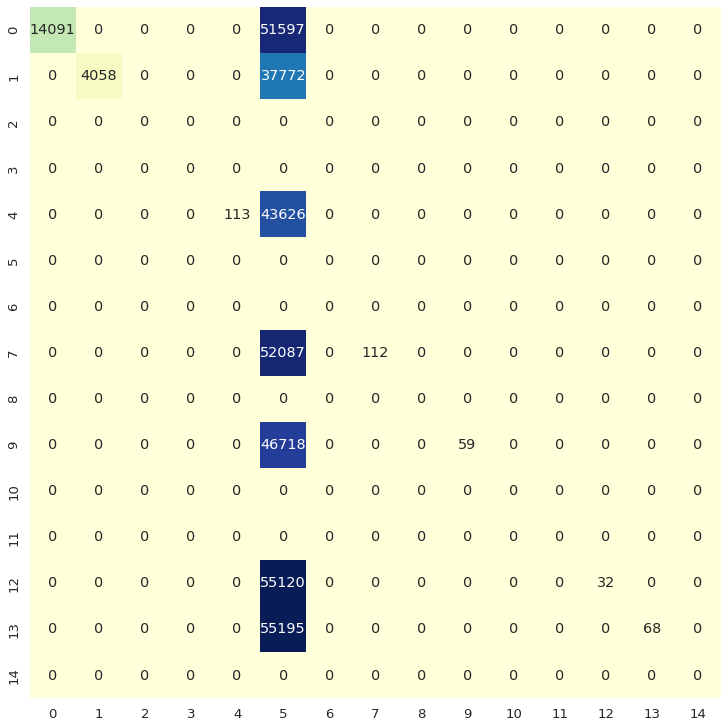

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale=1.2)
fig = plt.figure(figsize=(10, 10), constrained_layout=True)
sns.heatmap(cm, annot=True, fmt="1g", cmap='YlGnBu', cbar=False)
plt.yticks(rotation=90)
fig.savefig('teste.png', dpi=230, tight_layout=True)

# `System` classifiers

## Preparing columns

In [ ]:
windows = RandomForestClassifier()

In [ ]:
', '.join(os_columns)

'attack, txpck, rxkB, txkB, rxcmp, txcmp, rxmcst, ifutil, kbmemfree, kbmemused, memused, kbbuffers, kbcached, kbcommit, commit, kbactive, kbinact, kbdirty, kbanonpg, kbslab, kbkstack, kbpgtbl, kbvmused, CPU, nice, sys, iowait, steal, irq, soft, guest, gnice, idle, pswpin, pswpout, proc, cswch, intr, sum, classe_atk_num_sysmon, classe_num_sysmon, ID1, ID2, ID3, ID4, ID5, ID6, ID7, ID8, ID9, ID10, ID11, ID12, ID13, ID14, ID15, ID16, ID17, ID18, ID19, ID20, ID21, ID22, classe_atk_num, classe_num, class_atk_sysmon, class_sysmon, class_atk_sysstat, class_sysstat'

In [ ]:
win_columns = [*os_columns[os_columns.index('ID1'):os_columns.index('ID22') + 1], 'attack', 'class_atk_sysmon', 'class_sysmon']

In [ ]:
linux_columns = [*os_columns[:os_columns.index('ID1')]]

## Evaluating RF over Linux features

In [ ]:
linux = RandomForestClassifier()
Xli = df[linux_columns].drop(['attack', 'classe_atk_num_sysmon', 'classe_num_sysmon'], axis=1)
yli = df['attack']
X_train_linux, X_test_linux, y_train_linux, y_test_linux = train_test_split(Xli, yli, random_state=42, test_size=0.3)

In [ ]:
linux.fit(X_train_linux, y_train_linux)

RandomForestClassifier()

In [ ]:
y_pred_li = linux.predict(X_test_linux)

In [ ]:
print(classification_report(y_test_linux, y_pred_li))

              precision    recall  f1-score   support

           0       0.81      0.66      0.72     35543
           1       0.71      0.84      0.77     35688

    accuracy                           0.75     71231
   macro avg       0.76      0.75      0.75     71231
weighted avg       0.76      0.75      0.75     71231



## Evaluating RF over Windows features

In [ ]:
windows = RandomForestClassifier()
Xw = df[win_columns].drop(['attack', 'class_atk_sysmon', 'class_sysmon'], axis=1)
yw = df['attack']
X_train_win, X_test_win, y_train_win, y_test_win = train_test_split(Xw, yw, random_state=42, test_size=0.3)

In [ ]:
windows.fit(X_train_win, y_train_win)

RandomForestClassifier()

In [ ]:
y_pred_win = windows.predict(X_test_win)

In [ ]:
print(classification_report(y_test_win, y_pred_win))

              precision    recall  f1-score   support

           0       0.96      0.31      0.47     35543
           1       0.59      0.99      0.74     35688

    accuracy                           0.65     71231
   macro avg       0.77      0.65      0.60     71231
weighted avg       0.77      0.65      0.60     71231



# Pseudocode

In [ ]:
def test(clf: MLPClassifier, system: object, tools_instances: np.ndarray, system_instances: np.ndarray) -> None:
    y_pred = clf.predict(tools_instances)

    snort_win = y_pred[:, 0]
    snort_linux = y_pred[:, 1]
    iptables = y_pred[:, 2]
    normal = y_pred[:, 3]

    tools = [snort_win, snort_linux, iptables]

    print(tools, normal)

    if normal == 0 and sum(tools) >= 2:
        print("SEND TO SCADA")

    if normal == 0 and sum(tools) == 1:
        if system.predict(system_instances)[0] == 1:
            print("HONEYPOT")
        print("SCADA")
    
    if normal == 0 and sum(tools) >= 2:
        print("HONEYPOT")
    
    if normal == 1 and sum(tools) == 1:
        print("I THINK IT'S A NORMAL TRAFFIC")
        if system.predict(system_instances)[0] == 0:
            print("HONEYPOT")
        print("BLOCK")
    
    if normal == 1 and sum(tools) >= 2:
        print("HONEYPOT")
    
    if normal == 0 and sum(tools) >= 2:
        print("BLOCK")

In [ ]:
yi = y_test[y_test['attack'] == 1].sample(n=1).index[0]
Xi = X_test.loc[yi]

In [ ]:
test(reg, windows, [Xi], [yi])

[array([0]), array([1]), array([1])] [1]
HONEYPOT
BLOCK
